In [2]:
!pip install --upgrade --user systemml

    100% |████████████████████████████████| 9.7MB 3.9MB/s eta 0:00:01    37% |████████████                    | 3.6MB 55.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.8.2 in /usr/local/src/conda3_runtime.v51/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from systemml) (1.13.3)
Requirement not upgraded as not directly required: scipy>=0.15.1 in /usr/local/src/conda3_runtime.v51/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from systemml) (1.0.0)
Requirement not upgraded as not directly required: pandas in /usr/local/src/conda3_runtime.v51/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from systemml) (0.21.0)
Requirement not upgraded as not directly required: scikit-learn in /usr/local/src/conda3_runtime.v51/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages (from systemml) (0.19.1)
Requirement not upgraded as not directly required: Pillow>=2.0.0 in /usr/local/src/conda3_runtime.v51/home/envs/DSX-Python35-Spark/lib/

In [3]:
!pip show systemml

Name: systemml
Version: 1.2.0
Summary: Apache SystemML is a distributed and declarative machine learning platform.
Home-page: http://systemml.apache.org/
Author: Apache SystemML
Author-email: dev@systemml.apache.org
License: Apache 2.0
Location: /gpfs/global_fs01/sym_shared/YPProdSpark/user/s4dd-37474e3926191a-8abd8ef3ba5d/.local/lib/python3.5/site-packages
Requires: numpy, Pillow, scipy, pandas, scikit-learn
Required-by: 


In [4]:
from systemml import MLContext, dml, dmlFromResource

ml = MLContext(sc)

print("Spark Version:", sc.version)
print("SystemML Version:", ml.version())
print("SystemML Built-Time:", ml.buildTime())

Spark Version: 2.1.3
SystemML Version: 0.15.0
SystemML Built-Time: 2017-09-08 08:50:38 UTC


### Hello world in SystemML

In [6]:
# Write the DML script
script = """
s = "Hello World";
"""
#Create python DML object
script = dml(script).output('s')

#Execute it using MLContext API
s = ml.execute(script).get('s')
print(s)

SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.


Hello World


### Matrix multiplication in SystemML

In [10]:
#Write DML script
script = """
    # nr is used input (number of rows)
    X = rand(rows=nr, cols=1000, sparsity=0.5)
    A = t(X) %*% X
    s = sum(A)
"""

#Create python DML object
script = dml(script).input(nr=1e5).output('s')

#Execute using MLContext API
s = ml.execute(script).get('s')
print(s)

SystemML Statistics:
Total execution time:		1.806 sec.
Number of executed Spark inst:	0.


6261015516.0997305


#### Generating random matrix in numpy and passing in to SystemML

In [9]:
import numpy as np
npMatrix = np.random.rand(1000, 1000)

#DML Script
script = """
    A = t(X) %*% X
    s = sum(A)
"""

#Python DML Object
script = dml(script).input(X=npMatrix).output('s')

#Execute it using MLContext API
script = ml.execute(script).get('s')
print(s)

SystemML Statistics:
Total execution time:		0.008 sec.
Number of executed Spark inst:	1.


625093564953.2737


# Diabetes dataset example

In [11]:
import matplotlib.pyplot as plt
from sklearn import datasets
plt.switch_backend('agg')

In [12]:
%matplotlib inline

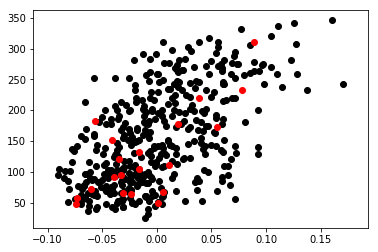

In [13]:
diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

### Linear regression - Algorithm 1
    Least square formulation

In [15]:
# Step 1: Write the DML script
script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

# Step 2: Create a Python DML object
script = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')

# Step 3: Execute it using MLContext API
w, bias = ml.execute(script).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.026 sec.
Number of executed Spark inst:	2.




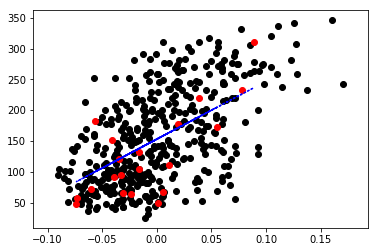

In [16]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue', linestyle ='dotted')

### Linear regression - Algorithm 2
    Batch gradient descent

In [17]:
# Step 1: Write the DML script
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

# Step 2: Create a Python DML object
script = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')

# Step 3: Execute it using MLContext API
w, bias = ml.execute(script).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.095 sec.
Number of executed Spark inst:	2.




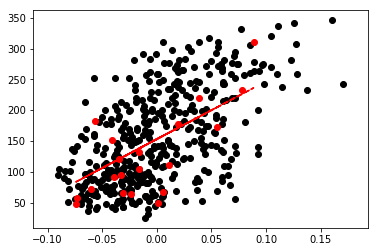

In [18]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

### Linear Regression - Algorithm 3
    Conjugate Gradient

In [19]:
# Step 1: Write the DML script
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

# Step 2: Create a Python DML object
script = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')

# Step 3: Execute it using MLContext API
w, bias = ml.execute(script).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.010 sec.
Number of executed Spark inst:	2.




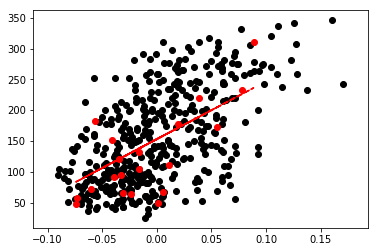

In [21]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')